In [1]:
from os import listdir
from os.path import join, splitext, basename
import glob
import torch.utils.data as data
import torchvision.transforms as trans
from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler
from PIL import Image
from imgaug import augmenters as iaa
from matplotlib.pyplot import figure, imshow, axis
import imgaug as ia
import numpy as np
import PIL
import torch
from PIL import Image
import matplotlib.pyplot as plt
import statistics
import random
import natsort
import copy
import collections
import torchvision.models as models
import torchvision
import torch.nn as nn
import torch.optim as optim

In [2]:
#To determine if your system supports CUDA
print("==> Check devices..")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Current device: ",device)

#Also can print your current GPU id, and the number of GPUs you can use.
print("Our selected device: ", torch.cuda.current_device())
print(torch.cuda.device_count(), " GPUs is available")

==> Check devices..
Current device:  cuda
Our selected device:  0
1  GPUs is available


In [3]:
class Config():
    def __init__(self):
        self.FolderNames2English_names = {
                                    '0':"Bread",          # 994 
                                    '1':"Dairy_product",  # 429
                                    '2':"Dessert",        # 1500
                                    '3':"Egg",            # 986
                                    '4':"Fried_food",     # 848
                                    '5':"Meat",           # 1325
                                    '6':"Noodles",        # 440
                                    '7':"Rice",           # 280
                                    '8':"Seafood",        # 855
                                    '9':"Soup",           # 1500
                                    '10':"Vegetable_fruit"# 709
                                    }
        self.folder_names2code = {}
        self.image_size = 224
        self.early_stop = 8
        self.max_epoch = 1000
        self.train_batchsize = 128
        self.eva_val_batchsize = 32
        self.class_num = 11
        self.each_class_item_num = {}
        self.temperature = 1
        self.alpha = 0.5
        
        
        self.train_dataset_path = r'./food11re/training'
        self.validation_dataset_path = r'./food11re/validation'
        self.test_dataset_path = r'./food11re/evaluation'
        self.model_ouput_dir = './model/'
        self.teacher_model_path = './teacher_model/7.pth'
        self.best_epoch = 0
        class_folder_name = listdir(self.test_dataset_path)
        self.class_folder_num = {}
        for cf in class_folder_name:
            self.class_folder_num[cf] = len(listdir(self.test_dataset_path + '/' + cf))
            
        
        self.net = 'resnet18'  # 0: resnet18
        self.teacher_net = 'resnet101'
        self.pretrain = False

        self.wts = [500/self.class_folder_num['0'], 500/self.class_folder_num['1'], 500/self.class_folder_num['2'], 
                    500/self.class_folder_num['3'], 500/self.class_folder_num['4'], 500/self.class_folder_num['5'], 
                    500/self.class_folder_num['6'], 500/self.class_folder_num['7'], 500/self.class_folder_num['8'], 
                    500/self.class_folder_num['9'], 500/self.class_folder_num['10']]
        self.lr = 0.0001
        self.criterion = nn.CrossEntropyLoss() #定義損失函數

In [4]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])

def load_img(filepath):
    img = Image.open(filepath)
    return img

In [5]:
class ImgAugTransform():
    def __init__(self, config=Config()):
        self.aug = iaa.Sequential([
            iaa.Scale((config.image_size, config.image_size)),
            iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
            iaa.Fliplr(0.5),
            iaa.Affine(rotate=(-20, 20), mode='symmetric'),
            iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),  # 對batch中的一部分圖片應用一部分Augmenters,剩下的圖片應用另外的Augmenters。
            iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)  # 即修改色調和飽和度
        ])
      
    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

In [6]:
def WRSampler(dataset, wts):
    class_name_list = dataset.classes
    num_per_classes = {}
    for img in dataset.imgs:
        if  img[1] not in num_per_classes:
            num_per_classes[int(img[1])] = 1
        else:
            num_per_classes[int(img[1])] += 1
            
    each_data_wts = []
    for class_name in class_name_list:
        class_item_num = num_per_classes[int(class_name)]
        for i in range(class_item_num):
            each_data_wts.append(wts[int(class_name)])
    
    sampler = torch.utils.data.sampler.WeightedRandomSampler(each_data_wts, len(each_data_wts), replacement=True)
    
    return sampler

In [7]:
def train(model, criterion, optimizer, max_epoch, train_loader, validation_loader, config):
    t_loss = []
    v_loss = []
    training_accuracy = []
    validation_accuracy = []
    total = 0
    min_val_loss = 0.0
    min_val_error = 0.0
    early_stop_timer = 0 

    for epoch in range(max_epoch):  # loop over the dataset multiple times
        train_loss = 0.0
        validation_loss = 0.0
        correct_train = 0
        correct_validation = 0
        train_num = 0
        val_num = 0
        train_img_num = 0
        validation_img_num = 0


        ########################
        # train the model      #
        ########################

        model.train()
        for i, (inputs, labels) in enumerate(train_loader, 0):

            #change the type into cuda tensor 
            inputs = inputs.to(device) 
            labels = labels.to(device) 

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            # select the class with highest probability
            _, pred = outputs.max(1)
            # if the model predicts the same results as the true
            # label, then the correct counter will plus 1
            correct_train += pred.eq(labels).sum().item()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            train_loss += loss.item()
            train_num += 1
            train_img_num += len(labels)


        ########################
        # validate the model   #
        ########################

        model.eval()
        for i, (inputs, labels) in enumerate(validation_loader, 0):
            # move tensors to GPU if CUDA is available
            inputs = inputs.to(device) 
            labels = labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(inputs)
            _, pred = outputs.max(1)
            correct_validation += pred.eq(labels).sum().item()
            # calculate the batch loss
            loss = criterion(outputs, labels)
            # update average validation loss 
            validation_loss += loss.item()
            val_num += 1
            validation_img_num += len(labels)


        if epoch % 1 == 0:    # print every 200 mini-batches
            val_error = 1 - correct_validation / validation_img_num
            print('[%d, %5d] train_loss: %.3f' % (epoch, max_epoch, train_loss / train_num))
            print('[%d, %5d] validation_loss: %.3f' % (epoch, max_epoch, validation_loss / val_num))
            print('%d epoch, training accuracy: %.4f' % (epoch, correct_train / train_img_num))
            print('%d epoch, validation accuracy: %.4f' % (epoch, correct_validation / validation_img_num))


            if epoch == 0:
                min_val_error = val_error
                print('Current best.')

            if val_error < min_val_error:
                min_val_error = val_error
                config.best_epoch = epoch
                early_stop_timer = 0
                print('Current best.')
            else:
                early_stop_timer += 1
                if early_stop_timer >= config.early_stop:
                    print('Early Stop.\nBest epoch is', str(config.best_epoch))
                    break
            t_loss.append(train_loss / train_num)
            training_accuracy.append(correct_train / train_img_num)
            validation_accuracy.append(correct_validation / validation_img_num)
            running_loss = 0.0
            validation_loss = 0.0
            train_num = 0
            val_num = 0
            correct_train = 0
            correct_validation = 0
            total = 0
            print('-----------------------------------------')

            torch.save(model.state_dict(), config.model_ouput_dir + str(epoch) + '.pth')

    print('Finished Training')

In [8]:
def get_teacher_outputs(teacher_model, inputs):
    teacher_model.eval()   
    teacher_outputs = teacher_model(inputs)
    
    return teacher_outputs

In [9]:
def loss_fn_kd(outputs, labels, teacher_outputs, config):
    """
    outputs        : training prediction of inputs.
    labels         : hard labels.
    teacher_outputs: soft labels.
    config         : config including alpha and temperature.
    """
    
    alpha = config.alpha
    temperature = config.temperature
    
    KD_loss = nn.KLDivLoss()(nn.functional.log_softmax(outputs/temperature, dim=1),
                             nn.functional.softmax(teacher_outputs/temperature, dim=1)) * (alpha * temperature * temperature) + \
                             nn.functional.cross_entropy(outputs, labels) * (1. - alpha)

    return KD_loss

In [10]:
def trainKD(model, teacher_model, criterion, optimizer, max_epoch, train_loader, validation_loader, config):
    t_loss = []
    v_loss = []
    training_accuracy = []
    validation_accuracy = []
    total = 0
    min_val_loss = 0.0
    min_val_error = 0.0
    early_stop_timer = 0 


    for epoch in range(max_epoch):  # loop over the dataset multiple times
        train_loss = 0.0
        validation_loss = 0.0
        correct_train = 0
        correct_validation = 0
        train_num = 0
        val_num = 0
        train_img_num = 0
        validation_img_num = 0


        ########################
        # train the model      #
        ########################

        model.train()
        for i, (inputs, labels) in enumerate(train_loader, 0):

            #change the type into cuda tensor 
            inputs = inputs.to(device) 
            labels = labels.to(device) 

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            teacher_outputs = get_teacher_outputs(teacher_model, inputs)
            
            _, pred = outputs.max(1)
            # if the model predicts the same results as the true
            # label, then the correct counter will plus 1
            correct_train += pred.eq(labels).sum().item()
            loss = loss_fn_kd(outputs, labels, teacher_outputs, config)
            loss.backward()
            optimizer.step()

            # print statistics
            train_loss += loss.item()
            train_num += 1
            train_img_num += len(labels)


        ########################
        # validate the model   #
        ########################

        model.eval()
        for i, (inputs, labels) in enumerate(validation_loader, 0):
            # move tensors to GPU if CUDA is available
            inputs = inputs.to(device) 
            labels = labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(inputs)
            _, pred = outputs.max(1)
            correct_validation += pred.eq(labels).sum().item()
            # calculate the batch loss
            loss = criterion(outputs, labels)
            # update average validation loss 
            validation_loss += loss.item()
            val_num += 1
            validation_img_num += len(labels)


        if epoch % 1 == 0:    # print every 200 mini-batches
            val_error = 1 - correct_validation / validation_img_num
            print('[%d, %5d] train_loss: %.3f' % (epoch, max_epoch, train_loss / train_num))
            print('[%d, %5d] validation_loss: %.3f' % (epoch, max_epoch, validation_loss / val_num))
            print('%d epoch, training accuracy: %.4f' % (epoch, correct_train / train_img_num))
            print('%d epoch, validation accuracy: %.4f' % (epoch, correct_validation / validation_img_num))


            if epoch == 0:
                min_val_error = val_error
                print('Current best.')
                
            if val_error < min_val_error:
                min_val_error = val_error
                config.best_epoch = epoch
                early_stop_timer = 0
                print('Current best.')
            else:
                early_stop_timer += 1
                if early_stop_timer >= config.early_stop:
                    print('Early Stop.\nBest epoch is', str(config.best_epoch))
                    break
            t_loss.append(train_loss / train_num)
            training_accuracy.append(correct_train / train_img_num)
            validation_accuracy.append(correct_validation / validation_img_num)
            running_loss = 0.0
            validation_loss = 0.0
            train_num = 0
            val_num = 0
            correct_train = 0
            correct_validation = 0
            total = 0
            print('-----------------------------------------')

            torch.save(model.state_dict(), config.model_ouput_dir + str(epoch) + '.pth')

    print('Finished Training')

In [11]:
def reload_net(config):
    print('-----------------------------------------')
    print('Reload', config.model_ouput_dir + '/' + str(config.best_epoch) + '.pth model.')
    print('-----------------------------------------')
    
    if config.net == 'resnet18':
        net = models.resnet18(pretrained=False)
        net.fc = nn.Sequential(nn.Linear(512,256),nn.LeakyReLU(),nn.Linear(256,128),nn.LeakyReLU(),nn.Linear(128,config.class_num))
        net.load_state_dict(torch.load(config.model_ouput_dir + '/' + str(config.best_epoch) + '.pth'))
    elif config.net == 'densenet121':
        net = models.densenet121(pretrained=False)
        net.fc = nn.Sequential(nn.Linear(1000,256),nn.LeakyReLU(),nn.Linear(256,128),nn.LeakyReLU(),nn.Linear(128,config.class_num))
        net.load_state_dict(torch.load(config.model_ouput_dir + '/' + str(config.best_epoch) + '.pth'))
    elif config.net == 'resnet101':
        net = models.resnet101(pretrained=False)
        net.fc = nn.Sequential(nn.Linear(2048,256),nn.LeakyReLU(),nn.Linear(256,128),nn.LeakyReLU(),nn.Linear(128,config.class_num))
        net.load_state_dict(torch.load(config.model_ouput_dir + '/' + str(config.best_epoch) + '.pth'))

    return net

In [12]:
def reload_teacher_net(config):
    print('-----------------------------------------')
    print('Reload', config.teacher_model_path, 'model.')
    print('-----------------------------------------')
    
    if config.teacher_net == 'resnet18':
        net = models.resnet18(pretrained=False)
        net.fc = nn.Sequential(nn.Linear(512,256),nn.LeakyReLU(),nn.Linear(256,128),nn.LeakyReLU(),nn.Linear(128,config.class_num))
        net.load_state_dict(torch.load(config.teacher_model_path))
    elif config.teacher_net == 'densenet121':
        net = models.densenet121(pretrained=False)
        net.fc = nn.Sequential(nn.Linear(1000,256),nn.LeakyReLU(),nn.Linear(256,128),nn.LeakyReLU(),nn.Linear(128,config.class_num))
        net.load_state_dict(torch.load(config.teacher_model_path))
    elif config.teacher_net == 'resnet101':
        net = models.resnet101(pretrained=False)
        net.fc = nn.Sequential(nn.Linear(2048,256),nn.LeakyReLU(),nn.Linear(256,128),nn.LeakyReLU(),nn.Linear(128,config.class_num))
        net.load_state_dict(torch.load(config.teacher_model_path))
    return net

In [13]:
def evaluation(model, evaluation_dataset, evaluation_loader, config):
    test_loss = 0.0
    correct_test = 0
    test_num = 0
    cls = np.zeros(config.class_num)
    correct_top3 = 0
    class_folder_num = config.class_folder_num
    
    model.eval()

    for i, (inputs, labels) in enumerate(evaluation_loader, 0):
        # move tensors to GPU if CUDA is available
        inputs = inputs.to(device) 
        labels = labels.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(inputs)
        _, pred = outputs.max(1)
        correct_test += pred.eq(labels).sum().item()
        _, top3 = outputs.topk(3)
        correct_top3 += top3.eq(labels.view(-1,1).expand_as(top3)).sum().item()

        for j in range(config.class_num):
            cls[j] += (pred.eq(j) * pred.eq(labels)).sum().item()

    print('Test set: Top 1 Accuracy: %d/%d (%.2f%%), Top 3 Accuracy: %d/%d (%.2f%%)' 
          % (correct_test, len(evaluation_dataset), correct_test / len(evaluation_dataset)*100, correct_top3, len(evaluation_dataset),
             correct_top3/ len(evaluation_dataset)*100))

    FN2EN = config.FolderNames2English_names

    print('%-20s : %d/%d    %10f%%' % (FN2EN['0'], cls[config.folder_names2code['0']], class_folder_num['0'], cls[config.folder_names2code['0']]/class_folder_num['0']*100))                                                    
    print('%-20s : %d/%d    %10f%%' % (FN2EN['1'], cls[config.folder_names2code['1']], class_folder_num['1'], cls[config.folder_names2code['1']]/class_folder_num['1']*100))
    print('%-20s : %d/%d    %10f%%' % (FN2EN['2'], cls[config.folder_names2code['2']], class_folder_num['2'], cls[config.folder_names2code['2']]/class_folder_num['2']*100))
    print('%-20s : %d/%d    %10f%%' % (FN2EN['3'], cls[config.folder_names2code['3']], class_folder_num['3'], cls[config.folder_names2code['3']]/class_folder_num['3']*100))
    print('%-20s : %d/%d    %10f%%' % (FN2EN['4'], cls[config.folder_names2code['4']], class_folder_num['4'], cls[config.folder_names2code['4']]/class_folder_num['4']*100))
    print('%-20s : %d/%d    %10f%%' % (FN2EN['5'], cls[config.folder_names2code['5']], class_folder_num['5'], cls[config.folder_names2code['5']]/class_folder_num['5']*100))
    print('%-20s : %d/%d    %10f%%' % (FN2EN['6'], cls[config.folder_names2code['6']], class_folder_num['6'], cls[config.folder_names2code['6']]/class_folder_num['6']*100))
    print('%-20s : %d/%d    %10f%%' % (FN2EN['7'], cls[config.folder_names2code['7']], class_folder_num['7'], cls[config.folder_names2code['7']]/class_folder_num['7']*100))
    print('%-20s : %d/%d    %10f%%' % (FN2EN['8'], cls[config.folder_names2code['8']], class_folder_num['8'], cls[config.folder_names2code['8']]/class_folder_num['8']*100))
    print('%-20s : %d/%d    %10f%%' % (FN2EN['9'], cls[config.folder_names2code['9']], class_folder_num['9'], cls[config.folder_names2code['9']]/class_folder_num['9']*100))
    print('%-20s : %d/%d    %10f%%' % (FN2EN['10'], cls[config.folder_names2code['10']], class_folder_num['10'], cls[config.folder_names2code['10']]/class_folder_num['10']*100))


    avg = []
    avg.append(cls[config.folder_names2code['0']]/class_folder_num['0']*100)
    avg.append(cls[config.folder_names2code['1']]/class_folder_num['1']*100)
    avg.append(cls[config.folder_names2code['2']]/class_folder_num['2']*100)
    avg.append(cls[config.folder_names2code['3']]/class_folder_num['3']*100)
    avg.append(cls[config.folder_names2code['4']]/class_folder_num['4']*100)
    avg.append(cls[config.folder_names2code['5']]/class_folder_num['5']*100)
    avg.append(cls[config.folder_names2code['6']]/class_folder_num['6']*100)
    avg.append(cls[config.folder_names2code['7']]/class_folder_num['7']*100)
    avg.append(cls[config.folder_names2code['8']]/class_folder_num['8']*100)
    avg.append(cls[config.folder_names2code['9']]/class_folder_num['9']*100)
    avg.append(cls[config.folder_names2code['10']]/class_folder_num['10']*100)

    print('Average per case accuracy: %10f%%' % (sum(avg)/len(avg)))
    print('-----------------------------------------')

In [14]:
if __name__ == '__main__':
    config = Config()
    #The transform function for train data
    transform_train = trans.Compose([
        ImgAugTransform(config),
        trans.ToTensor(),
        trans.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    #The transform function for validation data
    transform_validation = trans.Compose([
        trans.Resize((config.image_size, config.image_size)),
        trans.ToTensor(),
        trans.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    #The transform function for test data
    transform_test = trans.Compose([
        trans.Resize((config.image_size, config.image_size)),
        trans.ToTensor(),
        trans.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])


    train_dataset = torchvision.datasets.ImageFolder(root = config.train_dataset_path ,transform=transform_train)
    validation_dataset = torchvision.datasets.ImageFolder(root = config.validation_dataset_path ,transform=transform_validation)
    evaluation_dataset = torchvision.datasets.ImageFolder(root = config.test_dataset_path ,transform=transform_test)

    sampler = WRSampler(train_dataset, config.wts)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.train_batchsize, sampler=sampler)
    validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=config.eva_val_batchsize, shuffle=False)
    evaluation_loader = torch.utils.data.DataLoader(evaluation_dataset, batch_size=config.eva_val_batchsize, shuffle=False)

    if config.net == 'resnet18':
        net = models.resnet18(pretrained=config.pretrain)
        net.fc = nn.Sequential(nn.Linear(512,256),nn.LeakyReLU(),nn.Linear(256,128),nn.LeakyReLU(),nn.Linear(128,config.class_num))
        net = net.to(device) 
    elif config.net == 'densenet121':
        net = models.densenet121(pretrained=config.pretrain)
        net.fc = nn.Sequential(nn.Linear(1000,256),nn.LeakyReLU(),nn.Linear(256,128),nn.LeakyReLU(),nn.Linear(128,config.class_num))
        net = net.to(device) 
    elif config.net == 'resnet101':
        net = models.resnet101(pretrained=config.pretrain)
        net.fc = nn.Sequential(nn.Linear(2048,256),nn.LeakyReLU(),nn.Linear(256,128),nn.LeakyReLU(),nn.Linear(128,config.class_num))
        net = net.to(device) 

    config.folder_names2code = train_dataset.class_to_idx
    max_epoch = config.max_epoch
    learning_rate = config.lr
    criterion = config.criterion
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=[0.9, 0.999]) #定優化函數
    
    #train(net, criterion, optimizer, max_epoch, train_loader, validation_loader, config)
    teacher_model = reload_teacher_net(config).to(device)
    trainKD(net, teacher_model, criterion, optimizer, max_epoch, train_loader, validation_loader, config)
    
    pretrain_net = reload_net(config).to(device)
    evaluation(pretrain_net, evaluation_dataset, evaluation_loader, config)

/root/anaconda3/envs/weienv/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  warn_deprecated(msg, stacklevel=3)


-----------------------------------------
Reload ./teacher_model/7.pth model.
-----------------------------------------


/root/anaconda3/envs/weienv/lib/python3.7/site-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


[0,  1000] train_loss: 1.155
[0,  1000] validation_loss: 1.982
0 epoch, training accuracy: 0.2582
0 epoch, validation accuracy: 0.2822
Current best.
-----------------------------------------
[1,  1000] train_loss: 1.026
[1,  1000] validation_loss: 1.873
1 epoch, training accuracy: 0.3483
1 epoch, validation accuracy: 0.3434
Current best.
-----------------------------------------
[2,  1000] train_loss: 0.923
[2,  1000] validation_loss: 1.716
2 epoch, training accuracy: 0.4132
2 epoch, validation accuracy: 0.4064
Current best.
-----------------------------------------
[3,  1000] train_loss: 0.863
[3,  1000] validation_loss: 1.632
3 epoch, training accuracy: 0.4534
3 epoch, validation accuracy: 0.4283
Current best.
-----------------------------------------
[4,  1000] train_loss: 0.800
[4,  1000] validation_loss: 1.595
4 epoch, training accuracy: 0.4952
4 epoch, validation accuracy: 0.4633
Current best.
-----------------------------------------
[5,  1000] train_loss: 0.768
[5,  1000] valid

/root/anaconda3/envs/weienv/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (91049764 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Test set: Top 1 Accuracy: 2276/3347 (68.00%), Top 3 Accuracy: 3012/3347 (89.99%)
Bread                : 225/368     61.141304%
Dairy_product        : 69/148     46.621622%
Dessert              : 239/500     47.800000%
Egg                  : 176/335     52.537313%
Fried_food           : 217/287     75.609756%
Meat                 : 335/432     77.546296%
Noodles              : 99/147     67.346939%
Rice                 : 50/96     52.083333%
Seafood              : 250/303     82.508251%
Soup                 : 433/500     86.600000%
Vegetable_fruit      : 183/231     79.220779%
Average per case accuracy:  66.274145%
-----------------------------------------


In [15]:
pretrain_net = reload_net(config).to(device)
evaluation(pretrain_net, evaluation_dataset, evaluation_loader, config)

-----------------------------------------
Reload ./model//38.pth model.
-----------------------------------------
Test set: Top 1 Accuracy: 2276/3347 (68.00%), Top 3 Accuracy: 3012/3347 (89.99%)
Bread                : 225/368     61.141304%
Dairy_product        : 69/148     46.621622%
Dessert              : 239/500     47.800000%
Egg                  : 176/335     52.537313%
Fried_food           : 217/287     75.609756%
Meat                 : 335/432     77.546296%
Noodles              : 99/147     67.346939%
Rice                 : 50/96     52.083333%
Seafood              : 250/303     82.508251%
Soup                 : 433/500     86.600000%
Vegetable_fruit      : 183/231     79.220779%
Average per case accuracy:  66.274145%
-----------------------------------------


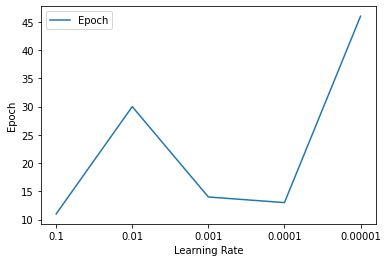

In [16]:
import matplotlib.pyplot as plt
x1 = [0, 1, 2, 3, 4]
y1 = [11, 30, 14, 13, 46]

plt.plot(x1, y1, '-', label='Epoch', markersize=10)
plt.xlabel('Learning Rate')
plt.ylabel('Epoch')
plt.legend()
plt.xticks([0, 1, 2, 3, 4], ['0.1', '0.01', '0.001', '0.0001', '0.00001'])
#plt.savefig('mAP_lrc.png')
plt.show()

In [17]:
models.resnet101(pretrained=config.pretrain)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 